## 🧪 Replicating the Vision Transformer (ViT) Paper with PyTorch

In this project, we aim to replicate the Vision Transformer (ViT) paper:  
**"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"**  
🔗 [Read the paper here](https://arxiv.org/abs/2010.11929)


### 🤔 Why Vision Transformers?

The Transformer architecture—originally developed for NLP in *"Attention Is All You Need"*—revolutionized how models understand sequential data using attention mechanisms. The ViT paper brought this architecture to computer vision by splitting images into patches (like words in a sentence) and processing them using a Transformer, rather than a convolutional network.

This project explores:
- Building a **ViT model from scratch** using PyTorch.
- Using the **CIFAR-10 dataset** for multi-class image classification.
- Reproducing the experimental setup as closely as possible to the original paper.

Let's dive into understanding how Transformers can be just as powerful for vision tasks as they are for language!


## 0. Getting setup

Before Starting the tasks, in order to make work easier and faster, let's turn the cell into Script mode and create files like:
image classification data.
1.  `engine.py` --> Contains functions for training and testing a PyTorch model.
2. `helper_functions.py` --> Utility functions for visualization of loss curves.

In [1]:
import os
os.mkdir("scripts")

In [2]:
%%writefile scripts/engine.py

"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Writing scripts/engine.py


In [3]:
%%writefile scripts/helper_functions.py

"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

Writing scripts/helper_functions.py


## Data Setup

we'll be using `CIFAR10` dataset from torchvision Library:
https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html

The `CIFAR-10` dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Load the Scripts file
# from scripts import data_setup, engine, utils, predictions

In [5]:
import os
os.cpu_count()

12

### 1.1 Prepare transforms for images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 1.2 Get Train and Test Datasets

In [7]:
train_data = torchvision.datasets.CIFAR10(root=".",
                                        train=True,
                                        download=True,
                                        transform=manual_transforms
                                        )
test_data = torchvision.datasets.CIFAR10(root=".",
                                        train=False,
                                        download=True,
                                        transform=manual_transforms
                                        )
len(train_data), len(test_data)

100%|██████████| 170M/170M [00:01<00:00, 99.5MB/s]


(50000, 10000)

### 2.3 Select random 10% of training and test data.

As the main goal is to replicate the paper not the accuracy measurement, we'll be using only 10% of the data randomly.

In [8]:
from torch.utils.data import random_split


# 1. Calculate the size of the 10% subset
total_size_train = len(train_data)
total_size_test = len(test_data)

train_data_10_percent = int(0.1 * total_size_train) # 10% of the total train data
test_data_10_percent = int(0.1 * total_size_test) # 10% of the total train data
remaining_size_train = total_size_train - train_data_10_percent
remaining_size_test = total_size_test - test_data_10_percent

# 2. Create a random split of the dataset
#    The dataset will be split into two parts: 10% for your subset and the remaining 90%.
train_data_subset, _ = random_split(train_data, [train_data_10_percent, remaining_size_train])
test_data_subset, _ = random_split(test_data, [test_data_10_percent, remaining_size_test])

# Now 'subset_dataset' contains 10% of the original STL10 training data.
# We can use this 'subset_dataset' with a DataLoader for your training or evaluation.
print(f"Total STL10 training dataset size: {total_size_train} Size of the 10% subset: {len(train_data_subset)}")
print(f"Total STL10 testing dataset size: {total_size_test} Size of the 10% subset: {len(test_data_subset)}")

Total STL10 training dataset size: 50000 Size of the 10% subset: 5000
Total STL10 testing dataset size: 10000 Size of the 10% subset: 1000


### 2.4 Turn images into `DataLoader`'s

Transforms created!

Let's now create our DataLoader's.

The ViT paper states the use of a batch size of 4096.

However, we're going to stick with a batch size of 32.

**Why?**

Because some hardware (including the free tier of Google Colab) may not be able to handle a batch size of 4096.

Having a batch size of 4096 means that 4096 images need to fit into the GPU memory at a time.

This works when you've got the hardware to handle it like a research team from Google often does but when you're running on a single GPU (such as using Google Colab), making sure things work with smaller batch size first is a good idea.

An extension of this project could be to try a higher batch size value and see what happens.

In [9]:
import os


# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small
NUM_WORKERS = os.cpu_count()

# Create data loaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_data_subset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=NUM_WORKERS,
                                               pin_memory=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_data_subset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=NUM_WORKERS,
                                               pin_memory=True)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x793dd01144d0>, <torch.utils.data.dataloader.DataLoader object at 0x793ccaa03150>)
Length of train dataloader: 157 batches of 32
Length of test dataloader: 32 batches of 32


### 2.3 Visualize a single image
Now we've loaded our data, let's visualize! it

An important step in the `ViT` paper is preparing the images into patches.



In [10]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(7))

Now let's plot the image and its label with matplotlib.


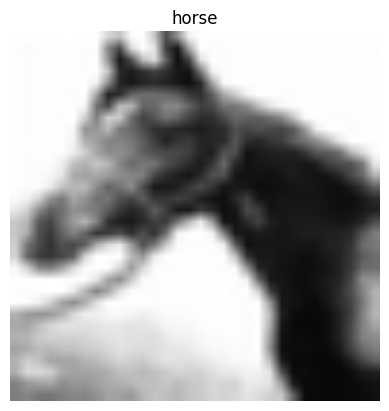

In [11]:
class_names = train_data.classes
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

Nice!

Looks like our images are importing correctly, let's continue with the paper replication.



## 2. Replicating the ViT paper: an overview
We'd like to replicate the ViT paper for our own problem, `CIFAR10` Datasets.

So our model inputs are: images of 10 classes contained in this dataset.



### 2.1 Inputs and outputs, layers and blocks
`ViT` is a deep learning neural network architecture.

And any neural network architecture is generally comprised of layers.

And a collection of layers is often referred to as a block.

And stacking many blocks together is what gives us the whole architecture.

A layer takes an input (say an image tensor), performs some kind of function on it (for example what's in the layer's `forward()` method) and then returns an output.

So if a single layer takes an input and gives an output, then a collection of layers or a block also takes an input and gives an output.

Let's make this concrete:

  > **Layer** - takes an input, performs a function on it, returns an output.

  > **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.

  > **Architecture (or model)** - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

This ideology is what we're going to be using to replicate the `ViT` paper.

We're going to take it layer by layer, block by block, function by function putting the pieces of the puzzle together like Lego to get our desired overall architecture.

The reason we do this is because looking at a whole research paper can be intimidating.

So for a better understanding, we'll break it down, starting with the inputs and outputs of single layer and working up to the inputs and outputs of the whole model.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-intputs-outputs-layers-and-blocks.png)

 ### 2.2 Getting specific: What's ViT made of?
 There are many little details about the ViT model sprinkled throughout the paper.

Finding them all is like one big treasure hunt!

Remember, a research paper is often months of work compressed into a few pages so it's understandable for it to take of practice to replicate.

However, the main three resources we'll be looking at for the architecture design are:

* **Figure 1** - This gives an overview of the model in a graphical sense, you could almost recreate the architecture with this figure alone.
* **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.

* **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

#### 2.2.1 Exploring Figure 1


![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png)

#### 2.2.2 Exploring the Four Equations
The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

These four equations represent the math behind the four major parts of the ViT architecture.

#### 2.2.3 Equation 1 overview

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

Where each of the elements in the vector is learnable (their requires_grad=True).



#### 2.2.4 Equation 2 overview
$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a skip/residual connection.

We'll call this layer the "MSA block".

In pseudocode, this might look like:
```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```
Notice the skip connection on the end (adding the input of the layers to the output of the layers).



#### 2.2.5 Equation 3 overview
$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \end{aligned} $$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:
```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```
Notice the skip connection on the end (adding the input of the layers to the output of the layers).



#### 2.2.6 Equation 4 overview
$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of x_output_MLP_block:

```python
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

#### 2.2.7 Exploring Table 1
The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model      | Layers | Hidden size $D$ | MLP size | Heads | Params  |
|------------|--------|------------------|----------|--------|---------|
| ViT-Base   | 12     | 768              | 3072     | 12     | $86M$   |
| ViT-Large  | 24     | 1024             | 4096     | 16     | $307M$  |
| ViT-Huge   | 32     | 1280             | 5120     | 16     | $632M$  |



## 3. Equation 1: Split data into patches and creating the class, position and patch embedding

The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.



### 3.1 Calculating patch embedding input and output shapes by hand

How about we start by calculating these input and output shape values by hand?

To do so, let's create some variables to mimic each of the terms (such as $H$, $W$ etc) above.

We'll use a patch size ($P$) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).

In [12]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


We've got the number of patches, how about we create the image output size as well?

Better yet, let's replicate the input and output shapes of the patch embedding layer.

Recall:

  1. **Input:** The image starts as 2D with size ${H \times W \times C}$.
  2. **Output:** The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.


In [13]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### 3.2 Turning a single image into patches
Now we know the ideal input and output shapes for our patch embedding layer, let's move towards making it.

Let's start with our single image.

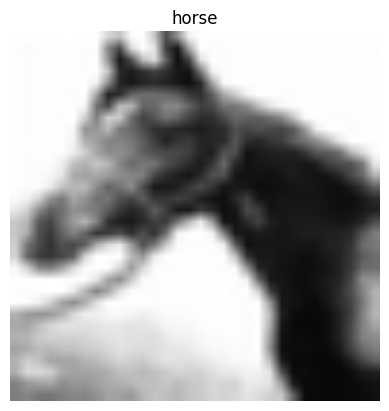

In [14]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

We want to turn this image into patches of itself inline with Figure 1 of the ViT paper.

How about we start by just visualizing the top row of patched pixels?

We can do this by indexing on the different image dimensions.



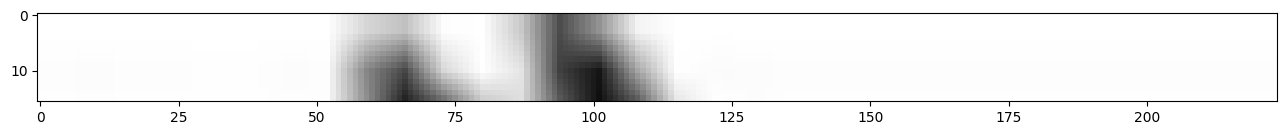

In [15]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Now we've got the top row, let's turn it into patches.

We can do this by iterating through the number of patches there'd be in the top row.


Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


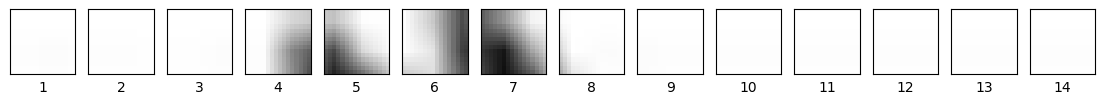

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

This time we'll iterate through the indexes for height and width and plot each patch as it's own subplot.



Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


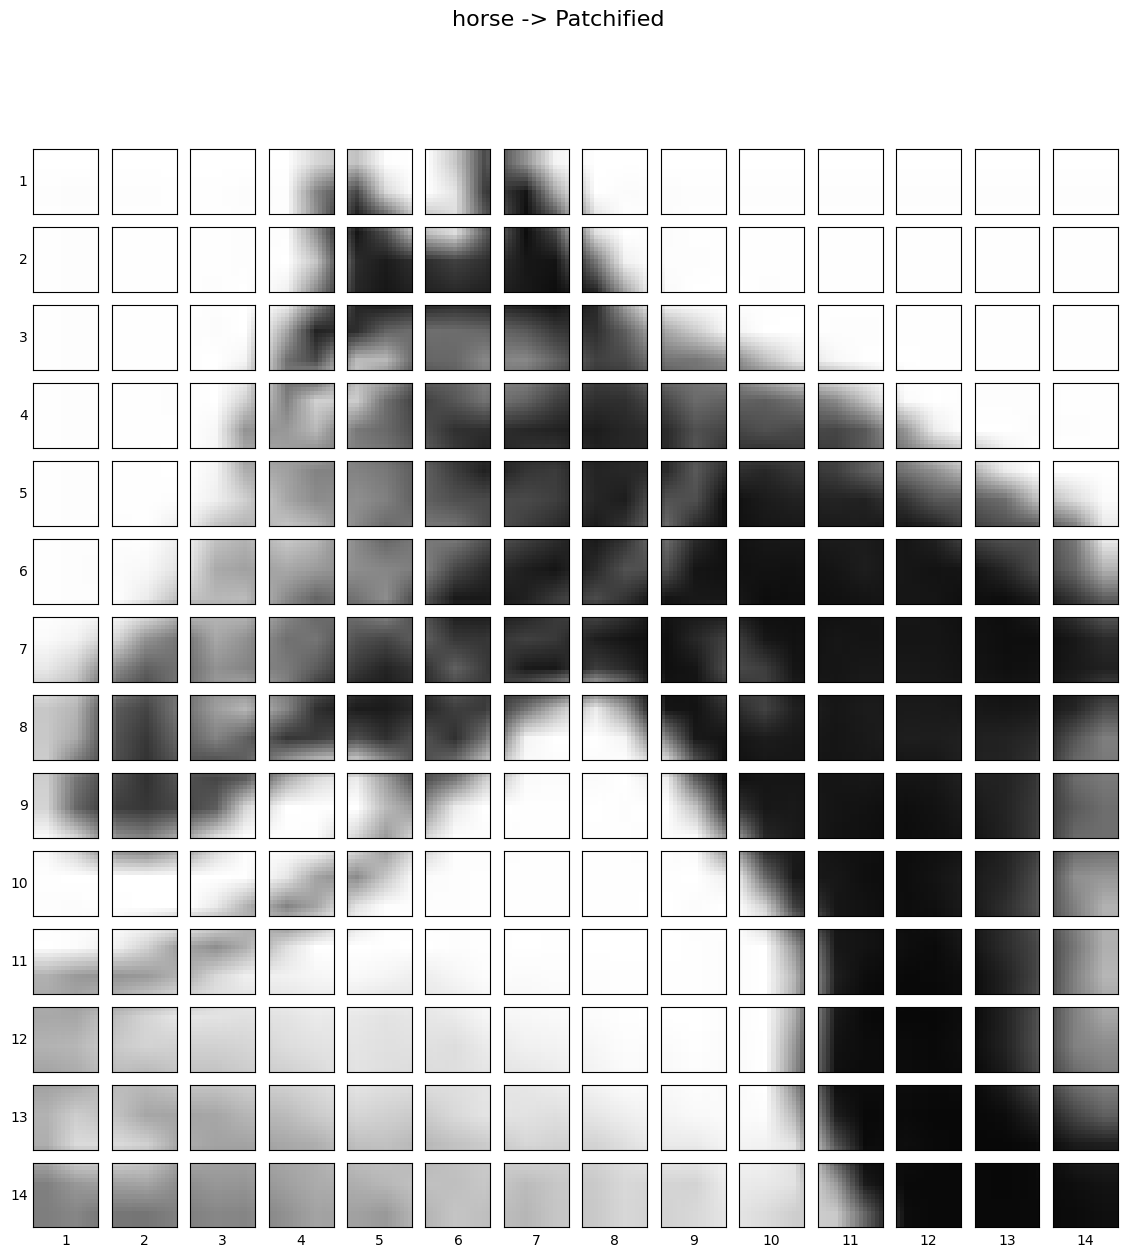

In [17]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()


Image patchified!

Woah, that looks cool.

Now we have to turn each of these patches into an embedding and convert them into a sequence.

### 3.3 Creating image patches with torch.nn.Conv2d()

In [18]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

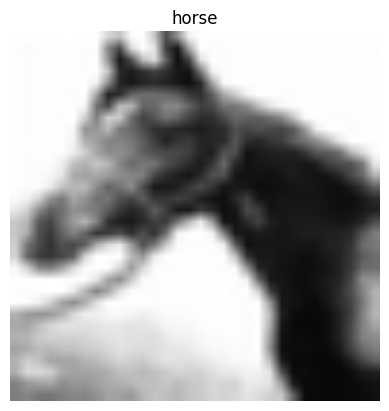

In [19]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [20]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [259, 434, 3, 23, 176]


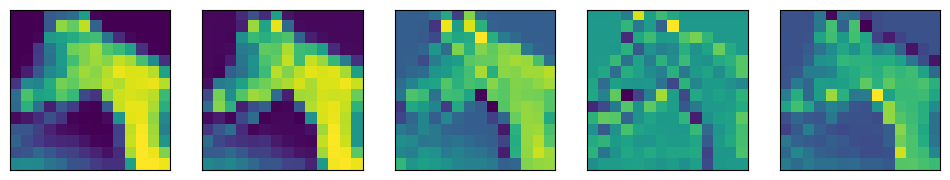

In [21]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

Notice how the feature maps all kind of represent the original image, after visualizing a few more you can start to see the different major outlines and some major features.

Let's check one out in numerical form.




In [22]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.6876,  0.6905,  0.6871,  0.4738,  0.7965,  0.3301,  0.6089,
            0.7325,  0.6915,  0.6891,  0.6891,  0.6891,  0.6891,  0.6891],
          [ 0.6831,  0.6857,  0.6838,  0.3876,  0.1593,  0.3988,  0.1469,
            0.8041,  0.6915,  0.6843,  0.6857,  0.6857,  0.6857,  0.6857],
          [ 0.6831,  0.6857,  0.6772,  0.2207,  0.1696,  0.1769,  0.0562,
            0.3062,  0.7057,  0.7374,  0.6936,  0.6860,  0.6857,  0.6857],
          [ 0.6831,  0.6841,  0.5595,  0.4921,  0.3328,  0.2422,  0.2446,
            0.1667,  0.3220,  0.3478,  0.5936,  0.7869,  0.6915,  0.6868],
          [ 0.6830,  0.6873,  0.5245,  0.3578,  0.2592,  0.1420,  0.0992,
            0.1014,  0.0739,  0.1342,  0.2033,  0.4243,  0.6791,  0.7677],
          [ 0.6805,  0.6421,  0.4787,  0.4291,  0.3501,  0.1625,  0.1150,
            0.1689,  0.0950,  0.0334,  0.0656,  0.0641,  0.2104,  0.5108],
          [ 0.6318,  0.4348,  0.4628,  0.2812,  0.2393,  0.1574,  0.1371,
            0.0889,  0.1084,  0.

### 3.4 Flattening the patch embedding with `torch.nn.Flatten()`

Desired output (1D sequence of flattened 2D patches): (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$


In [23]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


Well we've got the 768 part ( $(P^{2} \cdot C)$ ) but we still need the number of patches ($N$).

Reading back through section 3.1 of the ViT paper it says (bold mine):

  > *As a special case, the patches can have spatial size $1 \times 1$, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.*



In [24]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Nice! Now let's put it all together!

We'll:

1. Take a single image.
2. Put in through the convolutional layer (conv2d) to turn the image into 2D feature maps (patch embeddings).
3. Flatten the 2D feature map into a single sequence.


Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


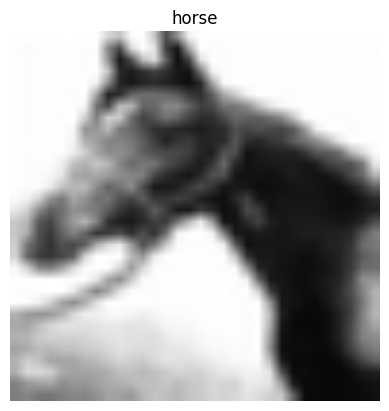

In [25]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Woohoo! It looks like our `image_out_of_conv_flattened` shape is very close to our desired output shape:

> Desired output (flattened 2D patches): (196, 768) -> ${N \times\left(P^{2} \cdot C\right)}$

> Current shape: (1, 768, 196)

The only difference is our current shape has a batch size and the dimensions are in a different order to the desired output.

We can do so with torch.Tensor.permute() just like we do when rearranging image tensors to plot them with matplotlib.



In [26]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


We've now matched the desired input and output shapes for the patch embedding layer of the ViT architecture using a couple of PyTorch layers.

How about we visualize one of the flattened feature maps?



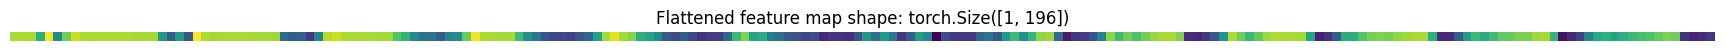

In [27]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

Hmm,

the flattened feature map doesn't look like much visually, but that's not what we're concerned about, this is what will be the output of the patching embedding layer and the input to the rest of the ViT architecture.

 > Note: The original Transformer architecture was designed to work with text. The Vision Transformer architecture (ViT) had the goal of using the original Transformer for images. This is why the input to the ViT architecture is processed in the way it is. We're essentially taking a 2D image and formatting it so it appears as a 1D sequence of text.

How about we view the flattened feature map in tensor form?




In [28]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.6876,  0.6905,  0.6871,  0.4738,  0.7965,  0.3301,  0.6089,  0.7325,
           0.6915,  0.6891,  0.6891,  0.6891,  0.6891,  0.6891,  0.6831,  0.6857,
           0.6838,  0.3876,  0.1593,  0.3988,  0.1469,  0.8041,  0.6915,  0.6843,
           0.6857,  0.6857,  0.6857,  0.6857,  0.6831,  0.6857,  0.6772,  0.2207,
           0.1696,  0.1769,  0.0562,  0.3062,  0.7057,  0.7374,  0.6936,  0.6860,
           0.6857,  0.6857,  0.6831,  0.6841,  0.5595,  0.4921,  0.3328,  0.2422,
           0.2446,  0.1667,  0.3220,  0.3478,  0.5936,  0.7869,  0.6915,  0.6868,
           0.6830,  0.6873,  0.5245,  0.3578,  0.2592,  0.1420,  0.0992,  0.1014,
           0.0739,  0.1342,  0.2033,  0.4243,  0.6791,  0.7677,  0.6805,  0.6421,
           0.4787,  0.4291,  0.3501,  0.1625,  0.1150,  0.1689,  0.0950,  0.0334,
           0.0656,  0.0641,  0.2104,  0.5108,  0.6318,  0.4348,  0.4628,  0.2812,
           0.2393,  0.1574,  0.1371,  0.0889,  0.1084,  0.0130,  0.0411,  0.0392,
           0.025

We've turned our single 2D image into a 1D learnable embedding vector (or "Linear Projection of Flattened Patches" in Figure 1 of the ViT paper).



### 3.5 Turning the ViT patch embedding layer into a PyTorch module
Time to put everything we've done for creating the patch embedding into a single PyTorch layer.

We can do so by subclassing nn.Module and creating a small PyTorch "model" to do all of the steps above.



In [29]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


PatchEmbedding layer created!

Let's try it out on a single image.

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


The output shape matches the ideal input and output shapes we'd like to see from the patch embedding layer:

Input: The image starts as 2D with size ${H \times W \times C}$.
Output: The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Let's now get a summary of our PatchEmbedding layer.



In [31]:
!pip install torchinfo

In [32]:
from torchinfo import summary
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 3.6 Creating the class token embedding

Okay we've made the image patch embedding, time to get to work on the class token embedding.

Or $\mathbf{x}_\text {class }$ from equation 1.

we need to "preprend a learnable embedding to the sequence of embedded patches".

Let's start by viewing our sequence of embedded patches tensor (created in section 4.5) and its shape.

In [33]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-1.0352,  0.2825, -0.2857,  ...,  0.7867, -0.4694,  0.3635],
         [-1.0358,  0.2839, -0.2866,  ...,  0.7899, -0.4715,  0.3624],
         [-1.0327,  0.2824, -0.2866,  ...,  0.7862, -0.4711,  0.3634],
         ...,
         [-0.0477, -0.0044, -0.0450,  ...,  0.0328, -0.0239,  0.0355],
         [-0.0557,  0.0027, -0.0410,  ...,  0.0379, -0.0210,  0.0142],
         [-0.0860,  0.0200, -0.0360,  ...,  0.0655, -0.0418,  0.0132]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Let's create a learnable embedding for the class token.

To do so, we'll get the batch size and embedding dimension shape and then we'll create a torch.ones() tensor in the shape [batch_size, 1, embedding_dimension].

And we'll make the tensor learnable by passing it to nn.Parameter() with requires_grad=True.



In [34]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [35]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-1.0352,  0.2825, -0.2857,  ...,  0.7867, -0.4694,  0.3635],
         [-1.0358,  0.2839, -0.2866,  ...,  0.7899, -0.4715,  0.3624],
         ...,
         [-0.0477, -0.0044, -0.0450,  ...,  0.0328, -0.0239,  0.0355],
         [-0.0557,  0.0027, -0.0410,  ...,  0.0379, -0.0210,  0.0142],
         [-0.0860,  0.0200, -0.0360,  ...,  0.0655, -0.0418,  0.0132]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 3.7 Creating the position embedding

Well, we've got the class token embedding and the patch embedding, now how might we create the position embedding?

Or $\mathbf{E}_{\text {pos }}$ from equation 1 where $E$ stands for "embedding".



In [36]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-1.0352,  0.2825, -0.2857,  ...,  0.7867, -0.4694,  0.3635],
          [-1.0358,  0.2839, -0.2866,  ...,  0.7899, -0.4715,  0.3624],
          ...,
          [-0.0477, -0.0044, -0.0450,  ...,  0.0328, -0.0239,  0.0355],
          [-0.0557,  0.0027, -0.0410,  ...,  0.0379, -0.0210,  0.0142],
          [-0.0860,  0.0200, -0.0360,  ...,  0.0655, -0.0418,  0.0132]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [37]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Position embeddings created!

Let's add them to our sequence of patch embeddings with a prepended class token.



In [38]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [-0.0352,  1.2825,  0.7143,  ...,  1.7867,  0.5306,  1.3635],
         [-0.0358,  1.2839,  0.7134,  ...,  1.7899,  0.5285,  1.3624],
         ...,
         [ 0.9523,  0.9956,  0.9550,  ...,  1.0328,  0.9761,  1.0355],
         [ 0.9443,  1.0027,  0.9590,  ...,  1.0379,  0.9790,  1.0142],
         [ 0.9140,  1.0200,  0.9640,  ...,  1.0655,  0.9582,  1.0132]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 3.8 Putting it all together: from image to embedding

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 4. Equation 2: Multi-Head Attention (MSA)

We've got our input data patchified and embedded, now let's move onto the next part of the ViT architecture.

To start, we'll break down the Transformer Encoder section into two parts (start small and increase when necessary).

The first being equation 2 and the second being equation 3.

Recall equation 2 states:

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

This indicates a Multi-Head Attention (MSA) layer wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output of the layer).

We'll refer to equation 2 as the "MSA block".



In saying this, to replicate these layers and residual connection with PyTorch code we can use:

Multi-Head Self Attention (MSA) - torch.nn.MultiheadAttention().
Norm (LN or LayerNorm) - torch.nn.LayerNorm().
Residual connection - add the input to output

### 4.1 The LayerNorm (LN) layer

Layer Normalization (`torch.nn.LayerNorm()` or Norm or LayerNorm or LN) normalizes an input over the last dimension.

What does it do?

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).





### 4.2 The Multi-Head Self Attention (MSA) layer

We can implement the MSA layer in PyTorch with torch.nn.MultiheadAttention() with the parameters:

  > `embed_dim` - the embedding dimension from Table 1 (Hidden size $D$).

> `num_heads` - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).
> `dropout` - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).

> `batch_first` - does our batch dimension come first? (yes it does)


### 4.3 Replicating Equation 2 with PyTorch layers

Let's put everything we've discussed about the LayerNorm (LN) and Multi-Head Attention (MSA) layers in equation 2 into practice.

To do so, we'll:

1. Create a class called `MultiheadSelfAttentionBlock` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 of the ViT paper for the `ViT-Base model`.
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the normalized_shape parameter the same as our embedding dimension ($D$ from Table 1).
4. Create a multi-head attention (MSA) layer with the appropriate `embed_dim`, `num_heads`, dropout and batch_first parameters.
5. Create a `forward()` method for our class passing the in the inputs through the LN layer and MSA layer.


In [40]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

MSABlock created!

Let's try it out by create an instance of our MultiheadSelfAttentionBlock and passing through the patch_and_position_embedding variable we created in section 4.8.



In [41]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## 5. Equation 3: Multilayer Perceptron (MLP)

Let's keep it going and replicate equation 3:

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \end{aligned} $$

Here MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above).

And the addition on the end is the skip/residual connection.

We'll refer to equation 3 as the "MLP block" of the Transformer encoder (notice how we're continuing the trend of breaking down the architecture into smaller chunks).



### 5.1 The MLP layer(s)

The term MLP is quite broad as it can refer to almost any combination of multiple layers (hence the "multi" in multilayer perceptron).

But it generally follows the pattern of:

```python
linear layer -> non-linear layer -> linear layer -> non-linear layer
```
In the the case of the ViT paper, the MLP structure is defined in section 3.1:

The MLP contains two layers with a `GELU` non-linearity.

Where "two layers" refers to linear layers (`torch.nn.Linear()` in PyTorch) and "`GELU` non-linearity" is the `GELU` (Gaussian Error Linear Units) non-linear activation function (`torch.nn.GELU()` in PyTorch).



### 5.2 Replicating Equation 3 with PyTorch layers

In [42]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

Let's try it out by create an instance of our MLPBlock and passing through the `patched_image_through_msa_block` variable we created in section 4.3.



In [43]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


Equation 3 replicated (except for the residual connection on the end but we'll get to this in section 6.1)!

## 6. Create the Transformer Encoder

Time to stack together our MultiheadSelfAttentionBlock (equation 2) and MLPBlock (equation 3) and create the Transformer Encoder of the ViT architecture.

In deep learning, an `"encoder"` or `"auto encoder"` generally refers to a stack of layers that "encodes" an input (turns it into some form of numerical representation).

In our case, the Transformer Encoder will encode our patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks, as per section 3.1 of the ViT Paper:



### 6.1 Creating a Transformer Encoder by combining our custom made layers

Enough talk,

let's see this in action and make a ViT Transformer Encoder with PyTorch by combining our previously created layers.

To do so, we'll:

1. Create a class called `TransformerEncoderBlock` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate a MSA block for equation 2 using our `MultiheadSelfAttentionBlock` from section 4.2 with the appropriate parameters.
4. Instantiate a MLP block for equation 3 using our MLPBlock from section 5.2 with the appropriate parameters.
5. Create a `forward()` method for our `TransformerEncoderBlock` class.
6. Create a residual connection for the MSA block (for equation 2).
7. Create a residual connection for the MLP block (for equation 3).


In [44]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

Transformer Encoder block created!

Let's get a `torchinfo.summary()` of passing an input of shape (1, 197, 768) -> (`batch_size, num_patches, embedding_dimension`) to our Transformer Encoder block.



In [45]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## 7. Putting it all together to create ViT

In [46]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

🕺💃🥳 Woohoo!!! We just built a vision transformer!


In [47]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


Let's create a random tensor in the same shape as a single image, pass to an instance of ViT and see what happens.



In [48]:
torch.manual_seed(42)

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.4452,  0.5503,  0.9471, -0.4082, -0.1517, -0.1520, -0.5361, -0.1304,
         -0.7799,  1.1546]], grad_fn=<AddmmBackward0>)

### 7.1 Getting a visual summary of our ViT model

In [49]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 10]             152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## 8. Setting up training code for our ViT model

In [52]:
from scripts import engine
from scripts import helper_functions

device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
helper_functions.set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=3,
                       device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5341 | train_acc: 0.0965 | test_loss: 2.3974 | test_acc: 0.1064
Epoch: 2 | train_loss: 2.3370 | train_acc: 0.0977 | test_loss: 2.3341 | test_acc: 0.1113
Epoch: 3 | train_loss: 2.3109 | train_acc: 0.0953 | test_loss: 2.3016 | test_acc: 0.1064


### 8.1 Plot the loss curves of our ViT model

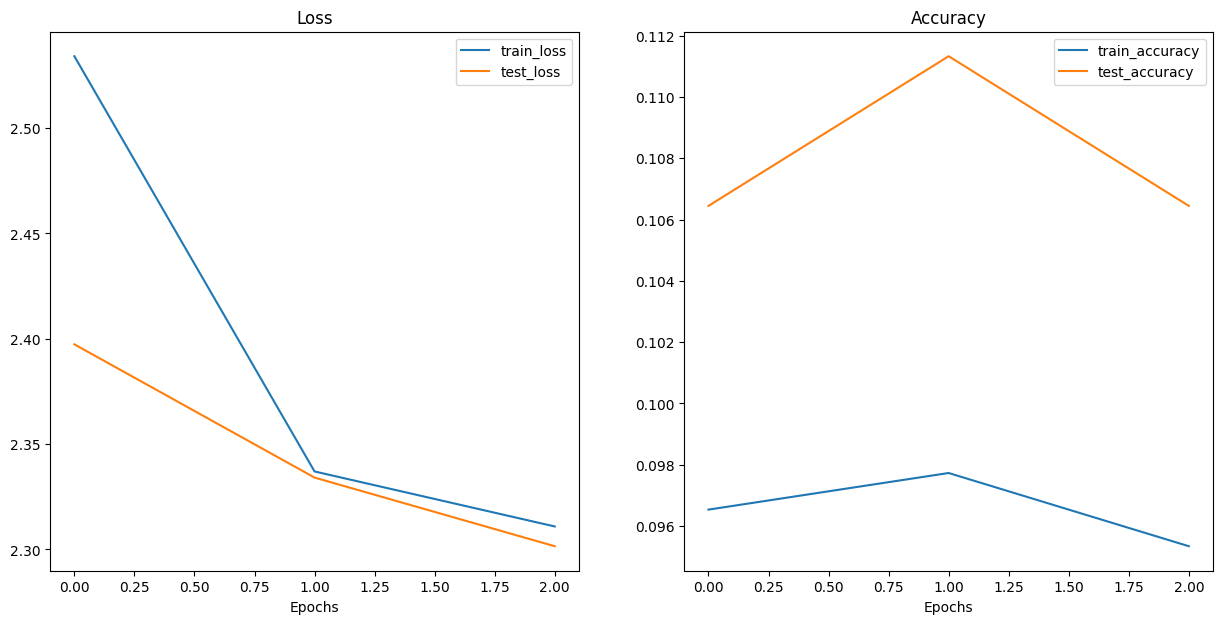

In [53]:
from scripts import helper_functions

# Plot our ViT model's loss curves
helper_functions.plot_loss_curves(results)

## ✅ Conclusion & Takeaways

In this project, we successfully recreated a simplified version of the Vision Transformer (ViT) using PyTorch, inspired by the original ViT paper.

### 🔍 Key Learnings:
- Transformers can be effectively adapted to image classification by treating image patches like word tokens.
- Unlike traditional CNNs, ViTs rely on attention mechanisms rather than convolutions to capture spatial relationships.
- PyTorch provides the flexibility needed to design custom architectures from scratch and replicate research effectively.

### 📈 Next Steps:
- Train the ViT on larger datasets like ImageNet or Tiny ImageNet for improved performance.
- Compare ViT against CNN baselines (e.g., ResNet) in terms of accuracy and training speed.
- Experiment with pre-trained transformer models via `timm` or Hugging Face's `transformers`.

### 🎯 Final Note:
Replicating papers is not just about accuracy—it’s about learning the underlying principles, dissecting architecture design, and gaining insights into how deep learning evolves. This project deepened that understanding and lays the groundwork for future experimentation with cutting-edge models.

